# Example 2: Running RFLO across conditions

Created: November 15, 2021

The following notebook creates a vanilla RNN and trains it on a center-out "reach" task. Here are some scenarios elaborated below:

* Velocity transformation of the neural activity
* Training `w_rec` alone and with `w_out`
* Training with and without driving feedback `w_fb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### 1. Training `w_rec` only, with velocity transformation

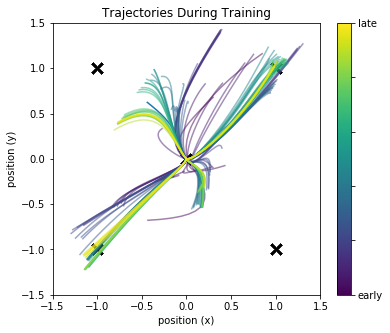

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.01,sig_out=0.01,
               velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec'],online=False) 


sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)


Note that we have not trained `w_out` at all, and are therefore forced to drive activity in a way that takes advantage of the readout matrix. We can also plot the trained trajectories

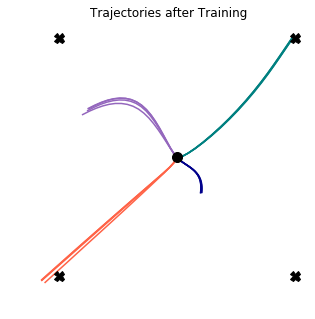

In [6]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


### 2. Training `w_rec` and `w_out`, with velocity transformation

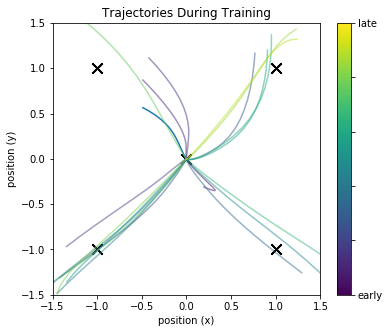

In [7]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.01,sig_out=0.01,
               velocity_transform=True, tau_vel = 5, dt_vel = 0.1,
               rng=np.random.RandomState(1))

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo = RFLO(net,apply_to=['w_rec','w_out'],online=True) 


sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=25)


This trains much more quickly, since we have control over both `w_rec` and `w_fb`

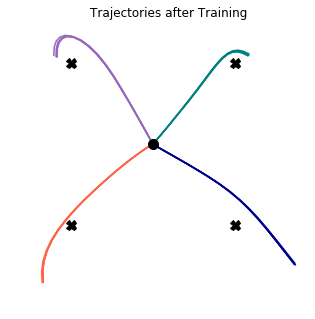

In [8]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


### 3. Training feedback `w_fb`, and no velocity transform

Note that here we are using *two* learning rules. First we are training `w_out` with RFLO for 100 trials, and then we are training `w_fb` with RFLO for 5000 trials

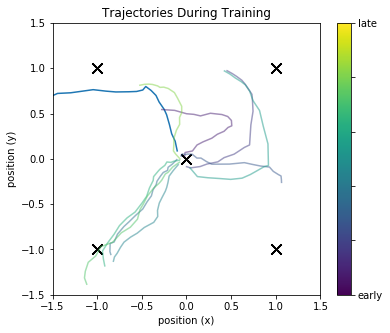

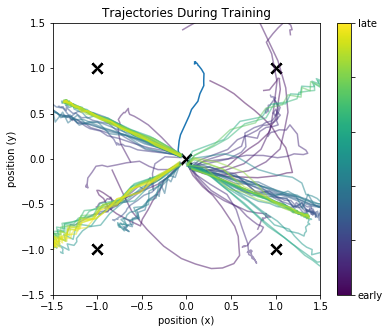

In [9]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=0.01,sig_out=0.01,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(1))

# Initialize RNN
net = RNN(params)

# set feedback weights to be the same as the transpose of w_out
net.set_weights(w_fb=np.copy(net.w_m))


# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_out']) 
sim.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

rflo = RFLO(net,apply_to=['w_fb'],online=False) 
sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=50)




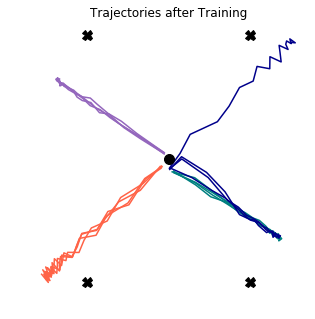

In [15]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])
